# Ofline learning, cleaner

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect
from plotting_functions import plot_weight_matrix, plot_state_variables_vs_time, plot_winning_pattern
from plotting_functions import plot_network_activity, plot_network_activity_angle
from analysis_functions import calculate_recall_time_quantities, calculate_angle_from_history, get_weights
from connectivity_functions import artificial_connectivity_matrix

#### Functions

In [2]:
def create_orthogonal_canonical_representation(minicolumns, hypercolumns):
    aux = []
    for i in range(minicolumns):
        aux.append(i * np.ones(hypercolumns))

    return np.array(aux, dtype='int')

def build_network_representation(matrix, minicolumns, hypercolumns):

    network_representation = np.zeros((len(matrix), minicolumns * hypercolumns), dtype='int')

    for patten, indexes in enumerate(matrix):
        for hypercolumn_index, minicolumn_index in enumerate(indexes):
            index = hypercolumn_index * minicolumns + minicolumn_index
            network_representation[patten, index] = 1
    
    return network_representation

In [3]:
class TimedInput:
    def __init__(self, minicolumns, hypercolumns, network_representation, dt, training_time, inter_pulse_interval=0.0,
                     inter_sequence_interval=0.0, epochs=1):
        
        self.n_units = network_representation.shape[1]
        self.dt = dt
        
        self.network_representation = network_representation
        self.epochs = epochs
        self.training_time = training_time
        self.inter_pulse_interval = inter_pulse_interval
        self.inter_sequence_interval = inter_sequence_interval
        
        self.n_patterns = network_representation.shape[0]
        self.pattern_length = int(training_time / dt)
        self.inter_pulse_interval_length = int(inter_pulse_interval / dt)
        self.inter_sequence_interval_length = int(inter_sequence_interval / dt)

        self.n_time_total = (self.pattern_length + self.inter_pulse_interval_length) * self.n_patterns
        self.n_time_total += self.inter_sequence_interval_length
        self.n_time_total *= epochs
        self.T_total = epochs * ((training_time + inter_pulse_interval) * n_patterns + inter_sequence_interval)
        self.time = np.linspace(0, self.T_total, num=self.n_time_total)

        
        self.S = np.zeros((self.n_units, self.n_time_total))
        self.z_pre = np.zeros_like(self.S)
        self.z_post = np.zeros_like(self.S)
        self.tau_z_pre = None
        self.tau_z_post = None

    def build_timed_input(self):      
        end = 0
        for epoch in range(self.epochs):
            for pattern in range(self.n_patterns):
                start = end
                end = start + self.pattern_length  
                indexes = np.where(self.network_representation[pattern])[0]
                self.S[indexes, start:end] = 1
                end += self.inter_pulse_interval_length
            end += self.inter_sequence_interval_length

        return self.S

    def build_filtered_input_pre(self, tau_z):
        self.tau_z_pre = tau_z
        for index, s in enumerate(self.S.T):
            if index == 0:
                self.z_pre[:, index] = (self.dt / tau_z) * (s - 0)
            else:
                self.z_pre[:, index] = self.z_pre[:, index - 1] + (self.dt / tau_z) * (s - self.z_pre[:, index - 1])

        return self.z_pre

    def build_filtered_input_post(self, tau_z):
        self.tau_z_post = tau_z
        for index, s in enumerate(self.S.T):
            if index == 0:
                self.z_post[:, index] = (self.dt / tau_z) * (s - 0)
            else:
                self.z_post[:, index] = self.z_post[:, index - 1] + (self.dt / tau_z) * (s - self.z_post[:, index - 1])

        return self.z_post
    
    def calculate_probabilities_from_time_signal(self, filtered=False):
        if filtered:
            y_pre = self.z_pre
            y_post = self.z_post
        else:
            y_pre = self.S
            y_post = self.S

        n_units = self.n_units
        n_time_total = self.n_time_total

        p_pre = sp.integrate.simps(y=y_pre, x=self.time, axis=1) / self.T_total
        p_post = sp.integrate.simps(y=y_post, x=self.time, axis=1) / self.T_total
        
        outer_product = np.zeros((n_units, n_units, n_time_total))
        for index, (s_pre, s_post) in enumerate(zip(y_pre.T, y_post.T)):
            outer_product[:, :, index] = s_post[:, np.newaxis] @ s_pre[np.newaxis, :]

        P = sp.integrate.simps(y=outer_product, x=self.time, axis=2) / self.T_total

        return p_pre, p_post, P

In [4]:
def get_probabilities_from_network_representation(network_representation):
    
    n_patterns = network_representation.shape[0]
    n_units = network_representation.shape[1]
    
    pi = network_representation.sum(axis=0) 
    
    pij = np.zeros((n_units, n_units))
    for pattern in network_representation:
        pij += pattern[:, np.newaxis] @ pattern[np.newaxis, :]

    pi = pi / n_patterns
    pij /= n_patterns
    
    return pi, pij

def get_weights_from_probabilities(pi, pj, pij, minicolumns, hypercolumns, small_number=10e-3):
    
    n_units = minicolumns * hypercolumns
    
    aux = np.copy(pi)
    aux[pi < small_number] = small_number
    beta = np.log(aux)

    w = np.zeros((n_units, n_units))
    for index1, p1 in enumerate(pi):
        for index2, p2 in enumerate(pj):
            if p1==0 or p2==0:
                w[index1, index2] = 1.0
            elif pij[index1, index2] < small_number:
                w[index1, index2] = small_number
            else:
                w[index1, index2] = pij[index1, index2] / (p1 * p2)

    w = np.log(w)
    
    return w

0.22360682571
0.316227805558


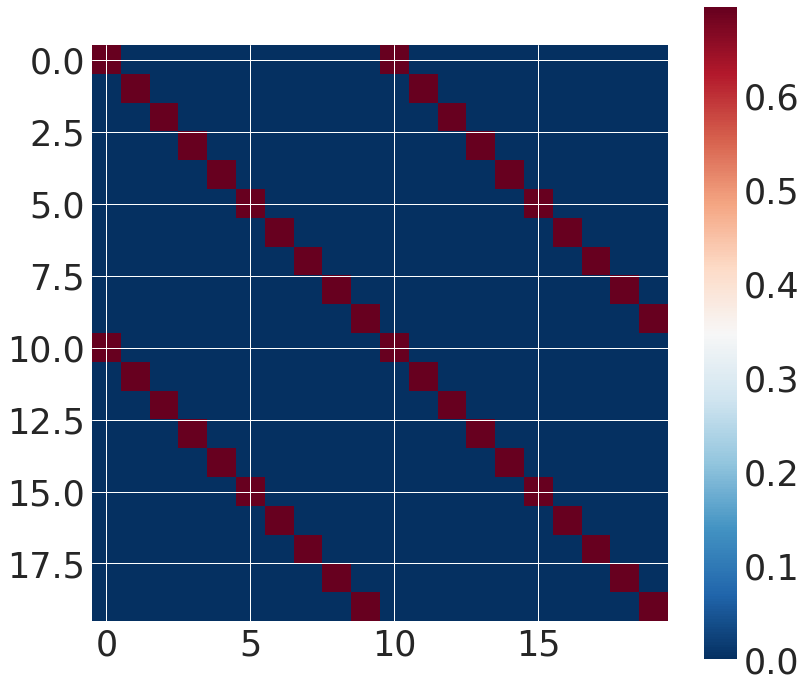

In [5]:
training_time = 0.100
n_patterns = 10
dt = 0.001
minicolumns = 10
hypercolumns = 2

matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

timed_input = TimedInput(minicolumns, hypercolumns, network_representation, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=1.0, epochs=3)
S = timed_input.build_timed_input()

pi, pij = get_probabilities_from_network_representation(network_representation)
w_static = get_weights_from_probabilities(pi, pi, pij, minicolumns, hypercolumns)

p_pre, p_post, P = timed_input.calculate_probabilities_from_time_signal(filtered=False)
w_timed = get_weights_from_probabilities(p_pre, p_post, P, minicolumns, hypercolumns)

print(np.linalg.norm(p_pre - pi))
print(np.linalg.norm(P - pij))

cmap = matplotlib.cm.RdBu_r
plt.imshow(w_timed - w_static, cmap=cmap)
plt.colorbar();

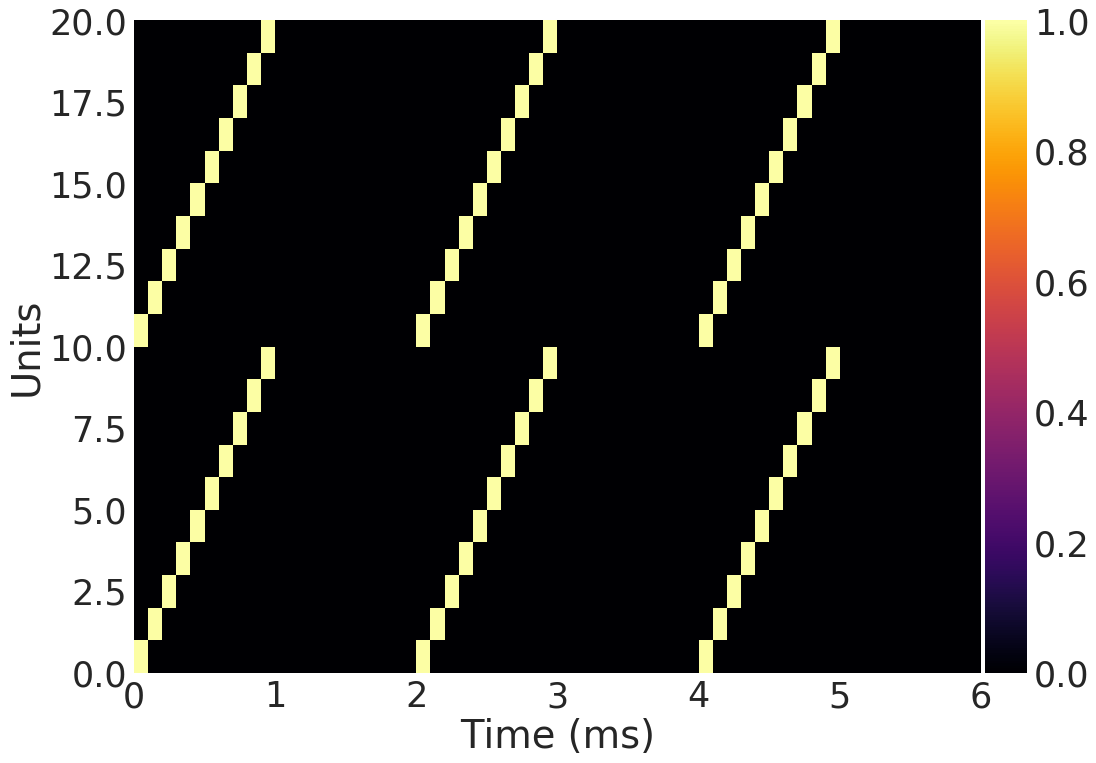

In [6]:
figsize = (16, 12)
cmap = matplotlib.cm.inferno

extent = [0, timed_input.T_total, 0, minicolumns * hypercolumns]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
im = ax.imshow(S, cmap=cmap, origin='lower', extent=extent, aspect='auto')
ax.grid(0)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Units')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

Let's filter

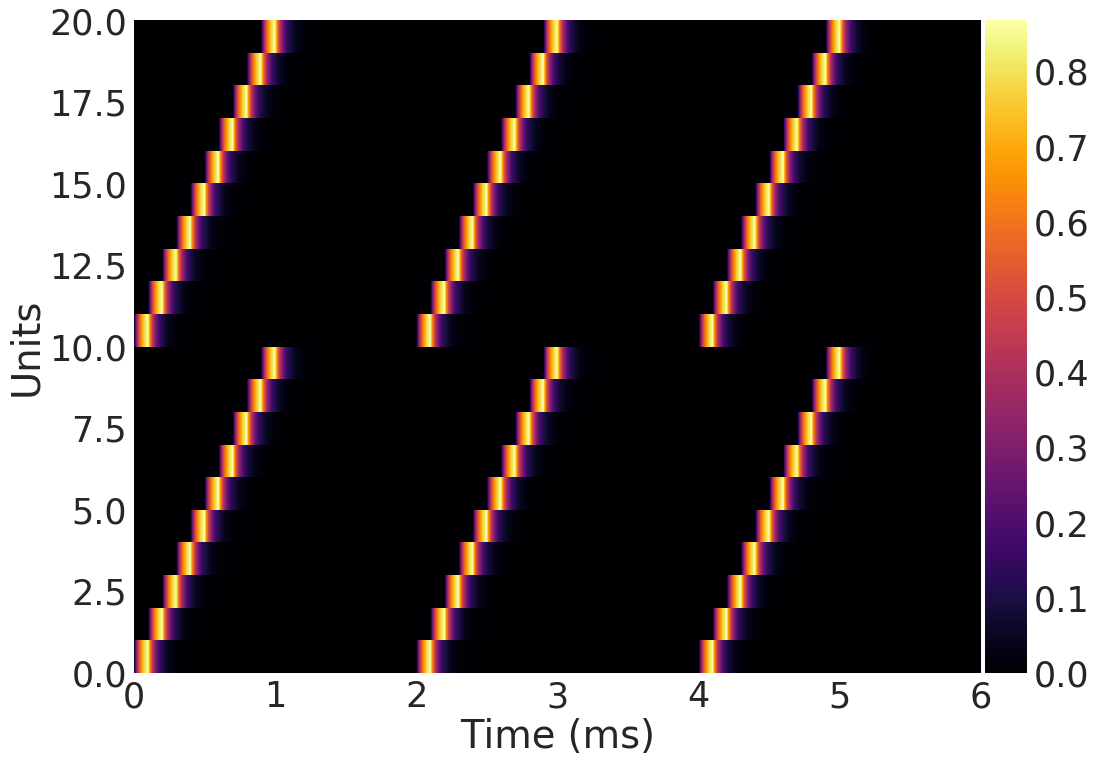

In [7]:
tau_z_pre = 0.050
z_pre = timed_input.build_filtered_input_pre(tau_z_pre)
tau_z_post = 0.001
z_post = timed_input.build_filtered_input_post(tau_z_post)

figsize = (16, 12)
cmap = matplotlib.cm.inferno

extent = [0, timed_input.T_total, 0, minicolumns * hypercolumns]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
im = ax.imshow(z_pre, cmap=cmap, origin='lower', extent=extent, aspect='auto')
ax.grid(0)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Units')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

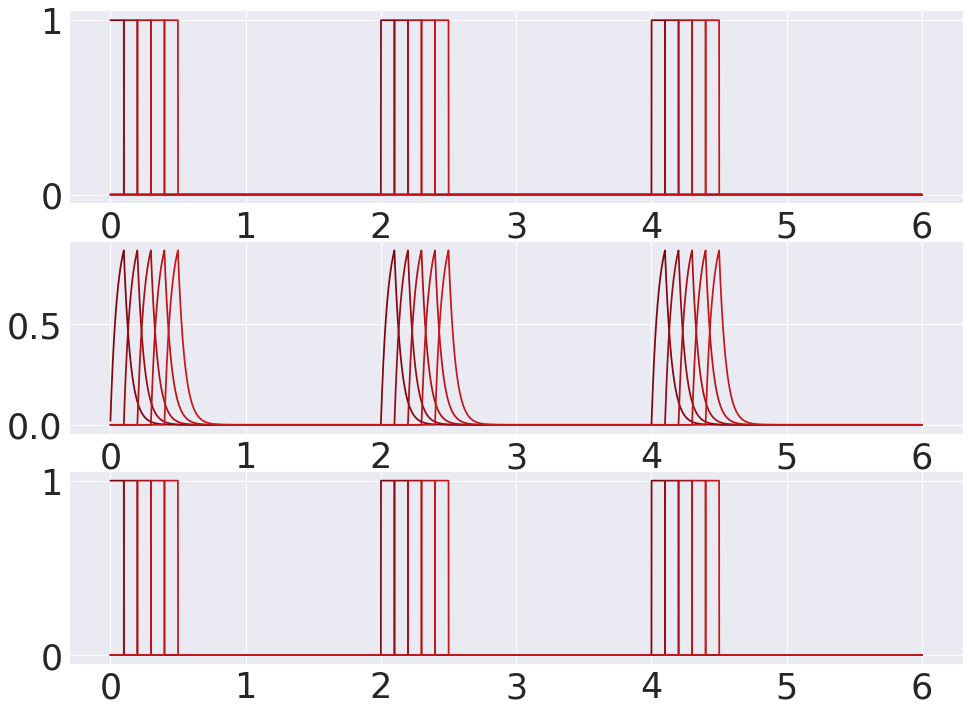

In [8]:
palette = sns.color_palette("Reds_r", S.shape[0])
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for index, s in enumerate(S):
    if index < 5:
        ax1.plot(timed_input.time, s, color=palette[index])
        ax2.plot(timed_input.time, z_pre[index, :], color=palette[index] )
        ax3.plot(timed_input.time, z_post[index, :], color=palette[index] )

Pij 1.97925938523e-18
pi * pj 0.00499249874979
ratio 3.96446646144e-16
log -35.4639902039


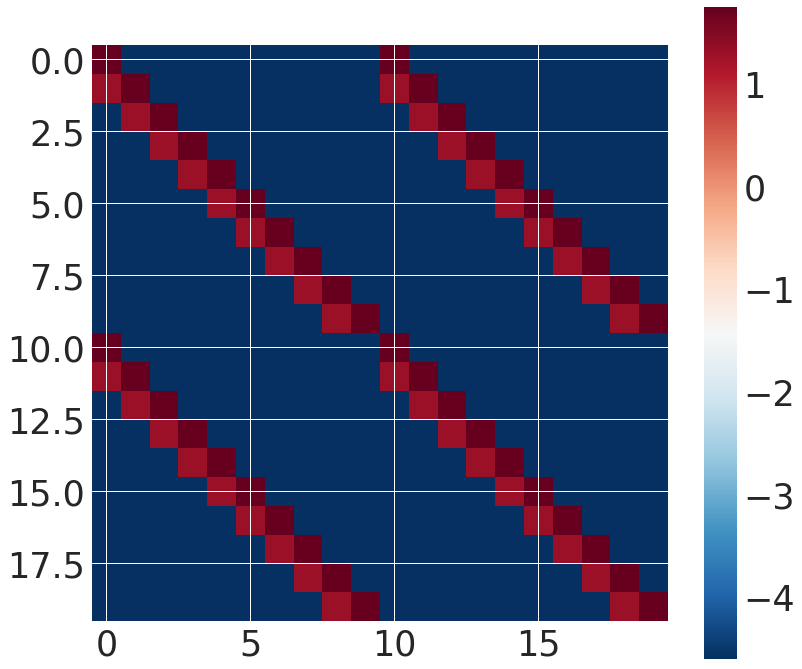

In [9]:
pj, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns)


to_index = 0
from_index = 1
print('Pij', P[to_index, from_index])
print('pi * pj', pi[from_index] * pj[to_index])
print('ratio', P[to_index, from_index] / (pi[from_index] * pj[to_index]))
print('log', np.log(P[to_index, from_index] / (pi[from_index] * pj[to_index])))

cmap = matplotlib.cm.RdBu_r
plt.imshow(w_timed, cmap=cmap)
plt.colorbar();

## Run it into the BCPNN network

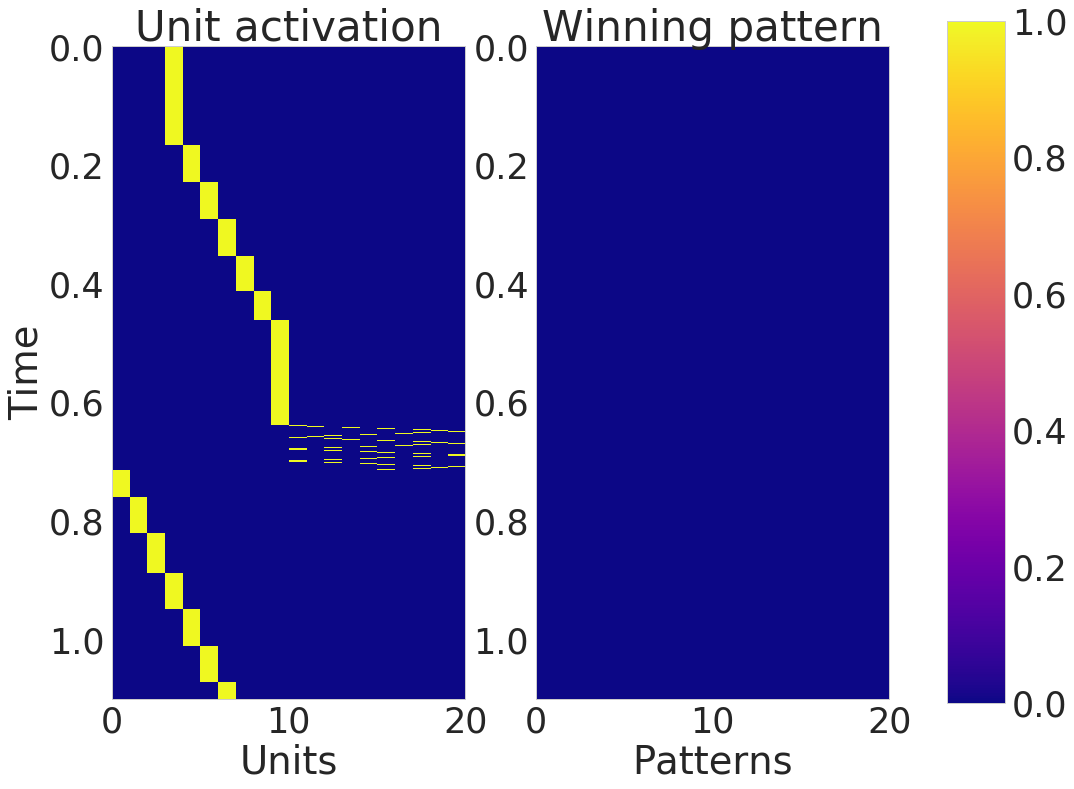

In [10]:
-

In [11]:
matrix[:n_patterns]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

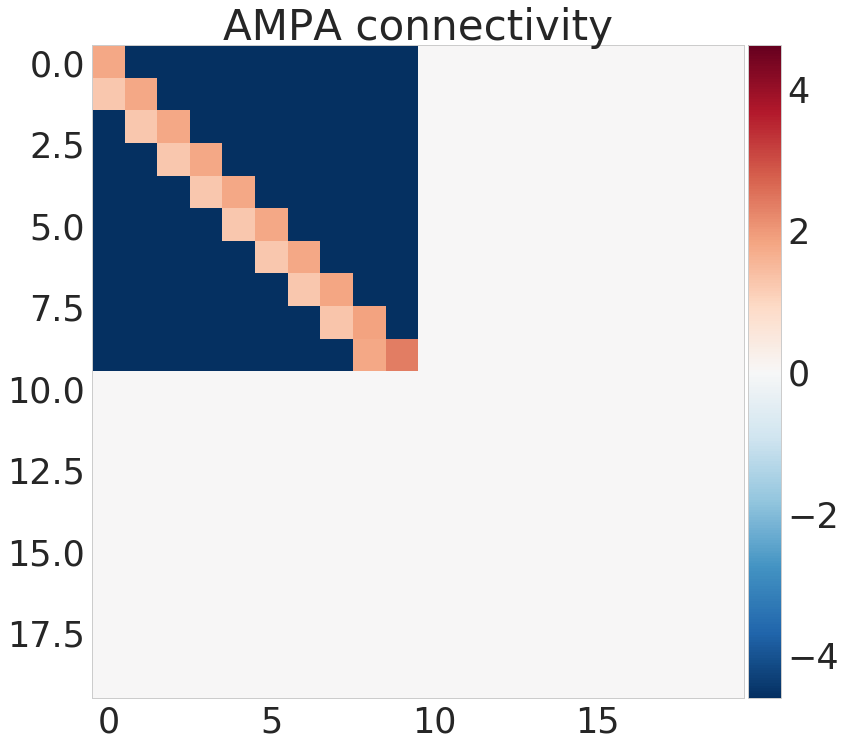

In [12]:
plot_weight_matrix(manager.nn, ampa=True, one_hypercolum=False)

In [13]:
matrix

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

## Let's learn overlaping sequences
First we need to create a matrix with two sequences

In [14]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 2
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1

# Recall
T_recall = 1.0
n = 1
T_cue = 0.050

matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

In [15]:
m1 = matrix[:5, :]
m2 = matrix[5:, :]

nr1 = build_network_representation(m1, minicolumns, hypercolumns)
nr2 = build_network_representation(m2, minicolumns, hypercolumns)

In [16]:
timed_input = TimedInput(minicolumns, hypercolumns, nr1, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=0.0, epochs=1)
S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)


pi1, pj1, P1 = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w_timed1 = get_weights_from_probabilities(pi1, pj1, P, minicolumns, hypercolumns)
t1 = timed_input.T_total

timed_input = TimedInput(minicolumns, hypercolumns, nr2, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=0.0, epochs=1)
S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)
t2 = timed_input.T_total

pi2, pj2, P2 = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w_timed2 = get_weights_from_probabilities(pi2, pj2, P, minicolumns, hypercolumns)
t_total = t1 + t2

pi_total = (t1 / t_total) * pi1 + ((t_total - t1)/ t_total) * pi2
pj_total = (t1 / t_total) * pj1 + ((t_total - t1)/ t_total) * pj2
P_total = (t1 / t_total) * P1 + ((t_total - t1)/ t_total) * P2
w_total = get_weights_from_probabilities(pi_total, pj_total, P_total, minicolumns, hypercolumns)
w_total2 = w_timed1 + w_timed2

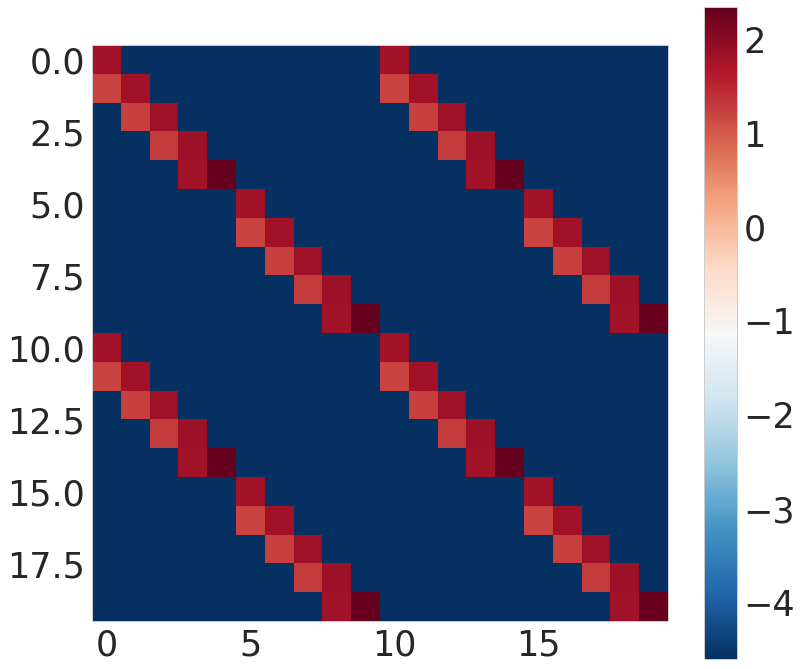

In [17]:
cmap = matplotlib.cm.RdBu_r
plt.imshow(w_total, cmap=cmap)
plt.colorbar();

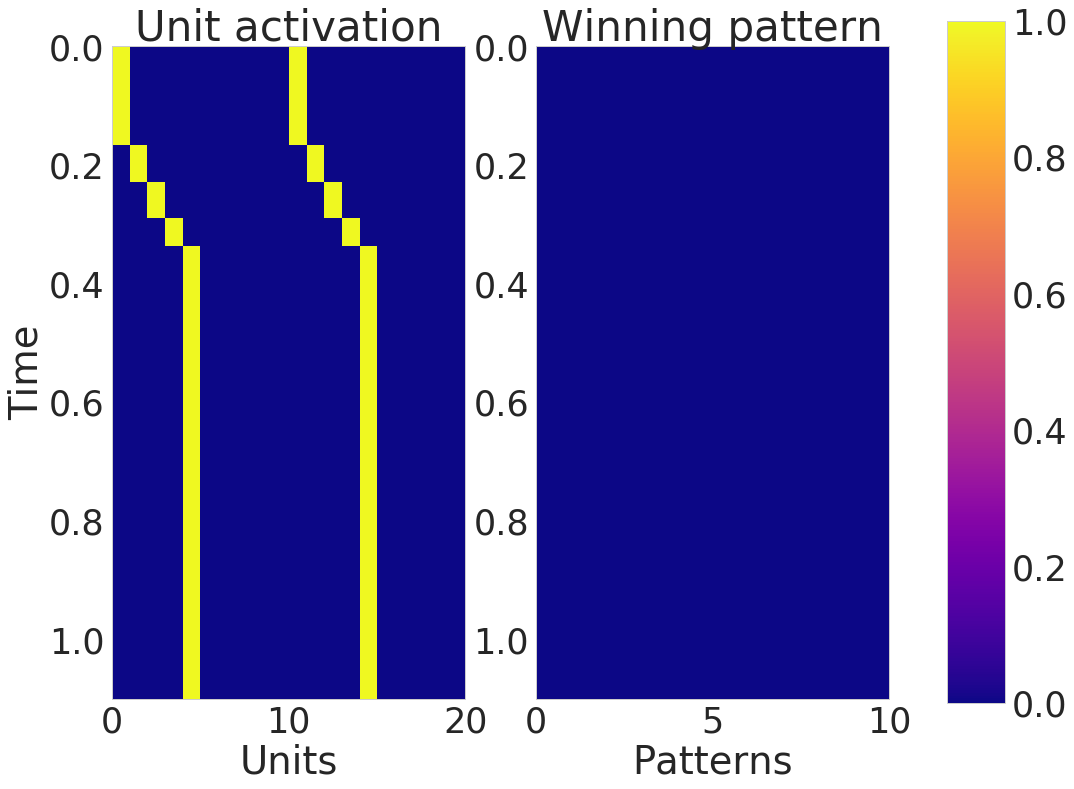

In [18]:
# Patterns parameters

nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
nn.w_ampa = w_total

# Recall
manager.run_network_recall(T_recall=1.0, T_cue=0.100, I_cue=nr1[0], reset=True, empty_history=True)

plot_network_activity_angle(manager)

Overlaping start

In [19]:
always_learning = False
strict_maximum = False
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 4
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1

# Recall
T_recall = 1.0
n = 1
T_cue = 0.050

matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

In [20]:
m1 = matrix[:5, :]
m2 = matrix[5:, :]
m2[3] = m1[3]
m2[3] = np.array((3, 3, 3, 8))
# m2[0] = np.array((0, 5, 5, 5))

nr1 = build_network_representation(m1, minicolumns, hypercolumns)
nr2 = build_network_representation(m2, minicolumns, hypercolumns)

In [21]:
m1

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3],
       [4, 4, 4, 4]])

In [22]:
m2

array([[5, 5, 5, 5],
       [6, 6, 6, 6],
       [7, 7, 7, 7],
       [3, 3, 3, 8],
       [9, 9, 9, 9]])

In [23]:
filtered = True

timed_input = TimedInput(minicolumns, hypercolumns, nr1, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=0.0, epochs=1)
S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)


pi1, pj1, P1 = timed_input.calculate_probabilities_from_time_signal(filtered=filtered)
w_timed1 = get_weights_from_probabilities(pi1, pj1, P1, minicolumns, hypercolumns)
t1 = timed_input.T_total

timed_input = TimedInput(minicolumns, hypercolumns, nr2, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=0.0, epochs=1)
S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)
t2 = timed_input.T_total

pi2, pj2, P2 = timed_input.calculate_probabilities_from_time_signal(filtered=filtered)
w_timed2 = get_weights_from_probabilities(pi2, pj2, P2, minicolumns, hypercolumns)
t_total = t1 + t2

pi_total = (t1 / t_total) * pi1 + ((t_total - t1)/ t_total) * pi2
pj_total = (t1 / t_total) * pj1 + ((t_total - t1)/ t_total) * pj2
P_total = (t1 / t_total) * P1 + ((t_total - t1)/ t_total) * P2
w_total = get_weights_from_probabilities(pi_total, pj_total, P_total, minicolumns, hypercolumns)
w_total2 = w_timed1 + w_timed2

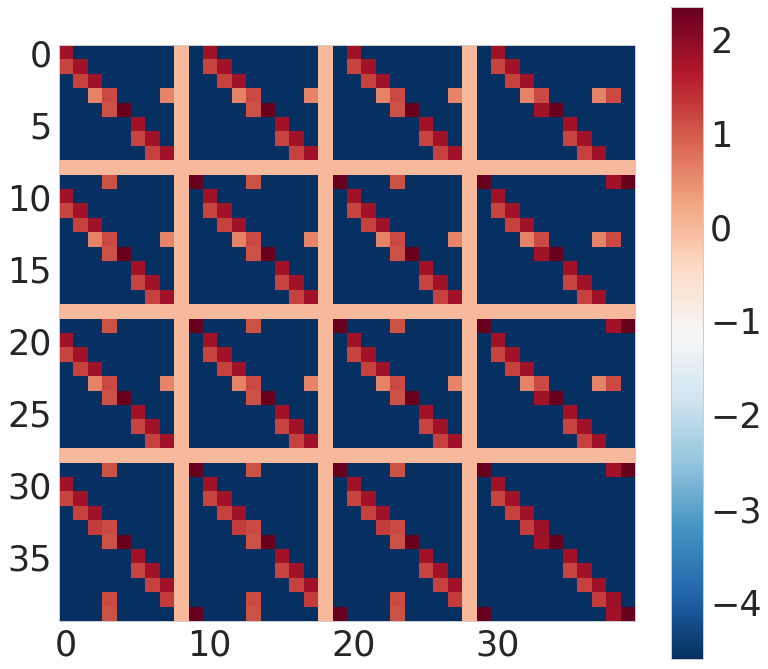

In [24]:
cmap = matplotlib.cm.RdBu_r
plt.imshow(w_total, cmap=cmap)
plt.colorbar();

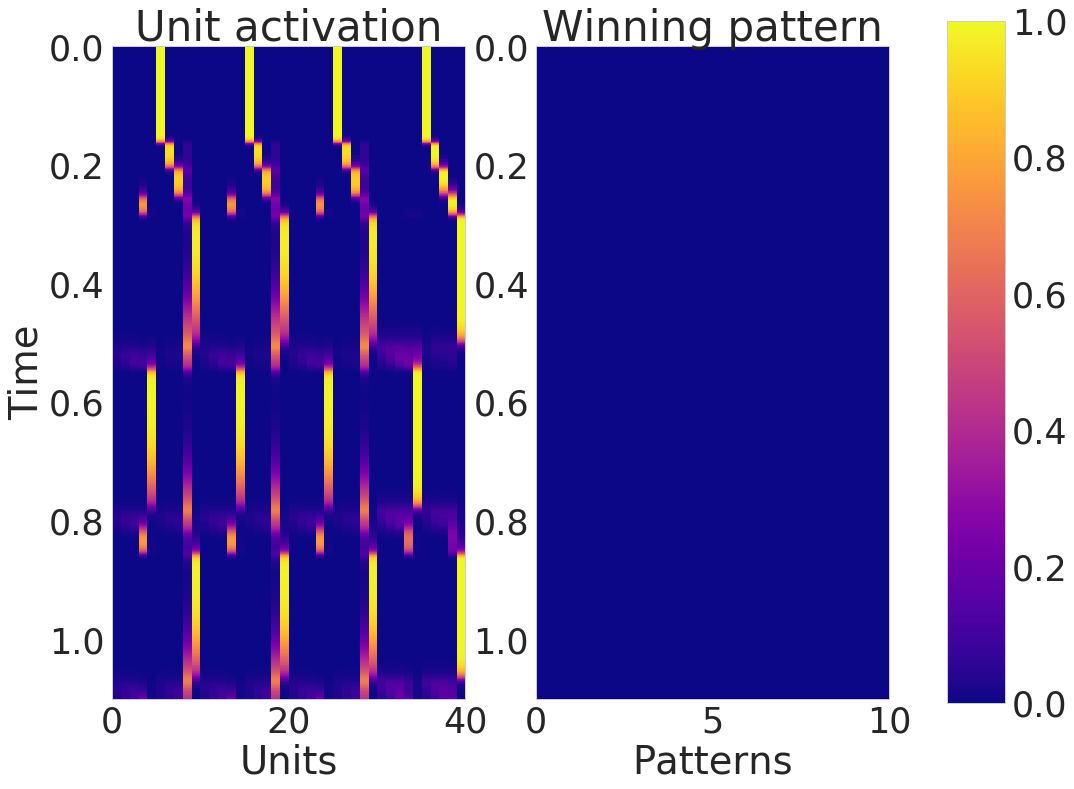

In [25]:
# Patterns parameters

nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
nn.w_ampa = w_total

# Recall
manager.run_network_recall(T_recall=1.0, T_cue=0.100, I_cue=nr2[0], reset=True, empty_history=True)

plot_network_activity_angle(manager)

## Mostly similar

In [160]:
always_learning = False
strict_maximum = False
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 3
minicolumns = 20
n_patterns = 8

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1

# Recall
T_recall = 1.0
n = 1
T_cue = 0.050

matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

In [161]:
matrix

array([[ 0,  0,  0],
       [ 1,  1,  1],
       [ 2,  2,  2],
       [ 3,  3,  3],
       [ 4,  4,  4],
       [ 5,  5,  5],
       [ 6,  6,  6],
       [ 7,  7,  7],
       [ 8,  8,  8],
       [ 9,  9,  9],
       [10, 10, 10],
       [11, 11, 11],
       [12, 12, 12],
       [13, 13, 13],
       [14, 14, 14],
       [15, 15, 15],
       [16, 16, 16],
       [17, 17, 17],
       [18, 18, 18],
       [19, 19, 19]])

In [166]:
aux = 10
m1 = matrix[:-aux]

In [170]:
m2 = np.copy(m1)
for i in range(aux):
    m2[i, hypercolumns - 1] = aux + i

In [171]:
m1

array([[0, 0, 0],
       [1, 1, 1],
       [2, 2, 2],
       [3, 3, 3],
       [4, 4, 4],
       [5, 5, 5],
       [6, 6, 6],
       [7, 7, 7],
       [8, 8, 8],
       [9, 9, 9]])

In [172]:
m2

array([[ 0,  0, 10],
       [ 1,  1, 11],
       [ 2,  2, 12],
       [ 3,  3, 13],
       [ 4,  4, 14],
       [ 5,  5, 15],
       [ 6,  6, 16],
       [ 7,  7, 17],
       [ 8,  8, 18],
       [ 9,  9, 19]])

In [ ]:
(0, 0, 0) -> (0, 0, 1) -> (0, 1, 1) -> (1, 1, 1)

In [173]:
nr1 = build_network_representation(m1, minicolumns, hypercolumns)
nr2 = build_network_representation(m2, minicolumns, hypercolumns)

In [174]:
filtered = True

timed_input = TimedInput(minicolumns, hypercolumns, nr1, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=0.0, epochs=1)
S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)


pi1, pj1, P1 = timed_input.calculate_probabilities_from_time_signal(filtered=filtered)
w_timed1 = get_weights_from_probabilities(pi1, pj1, P1, minicolumns, hypercolumns)
t1 = timed_input.T_total

timed_input = TimedInput(minicolumns, hypercolumns, nr2, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=0.0, epochs=1)
S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)
t2 = timed_input.T_total

pi2, pj2, P2 = timed_input.calculate_probabilities_from_time_signal(filtered=filtered)
w_timed2 = get_weights_from_probabilities(pi2, pj2, P2, minicolumns, hypercolumns)
t_total = t1 + t2

pi_total = (t1 / t_total) * pi1 + ((t_total - t1)/ t_total) * pi2
pj_total = (t1 / t_total) * pj1 + ((t_total - t1)/ t_total) * pj2
P_total = (t1 / t_total) * P1 + ((t_total - t1)/ t_total) * P2
w_total = get_weights_from_probabilities(pi_total, pj_total, P_total, minicolumns, hypercolumns)
w_total2 = w_timed1 + w_timed2

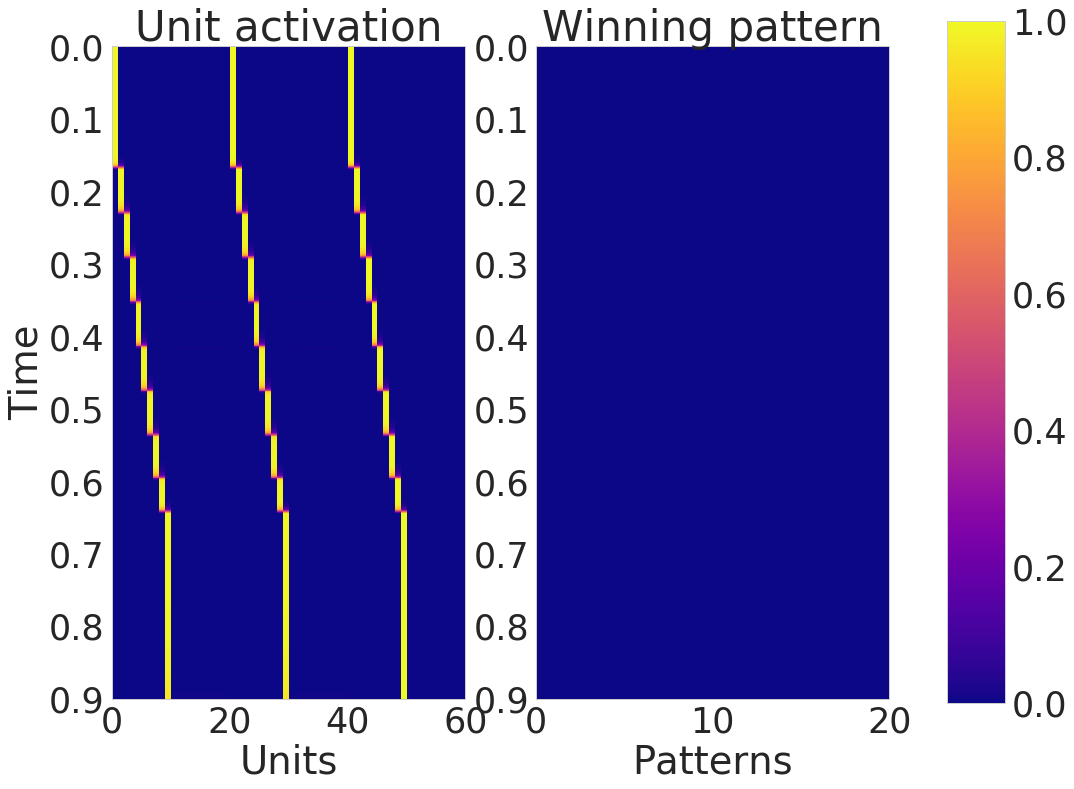

In [180]:
g_w_ampa = 5.0

nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
nn.w_ampa = w_total

# Recall
manager.run_network_recall(T_recall=0.8, T_cue=0.100, I_cue=nr1[0], reset=True, empty_history=True)
# manager.run_network_recall(T_recall=1.0, T_cue=0.100, I_cue=nr2[0], reset=False, empty_history=False)

plot_network_activity_angle(manager)

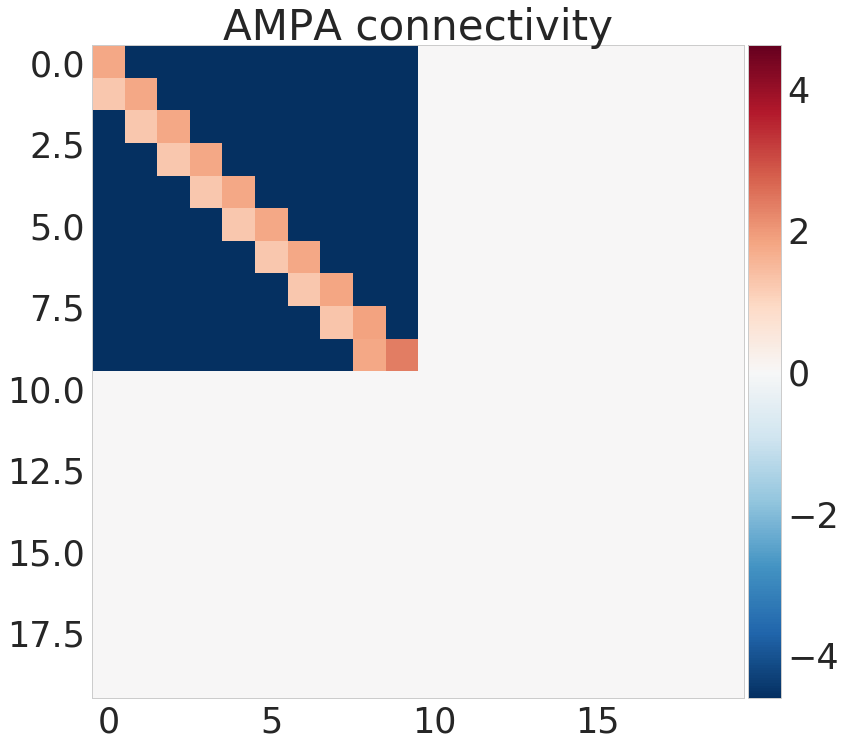

In [179]:
plot_weight_matrix(manager.nn, ampa=True)

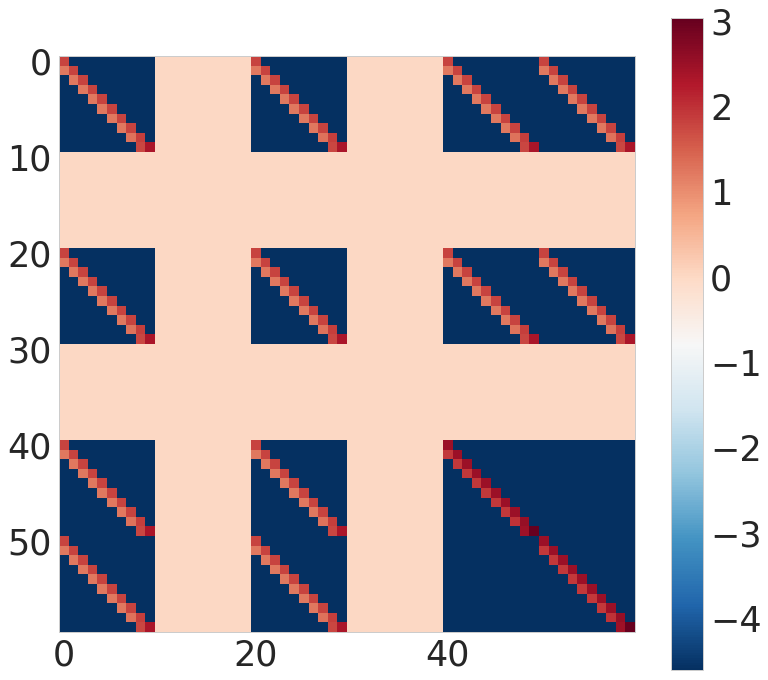

In [177]:
cmap = matplotlib.cm.RdBu_r
plt.imshow(w_total, cmap=cmap)
plt.colorbar();

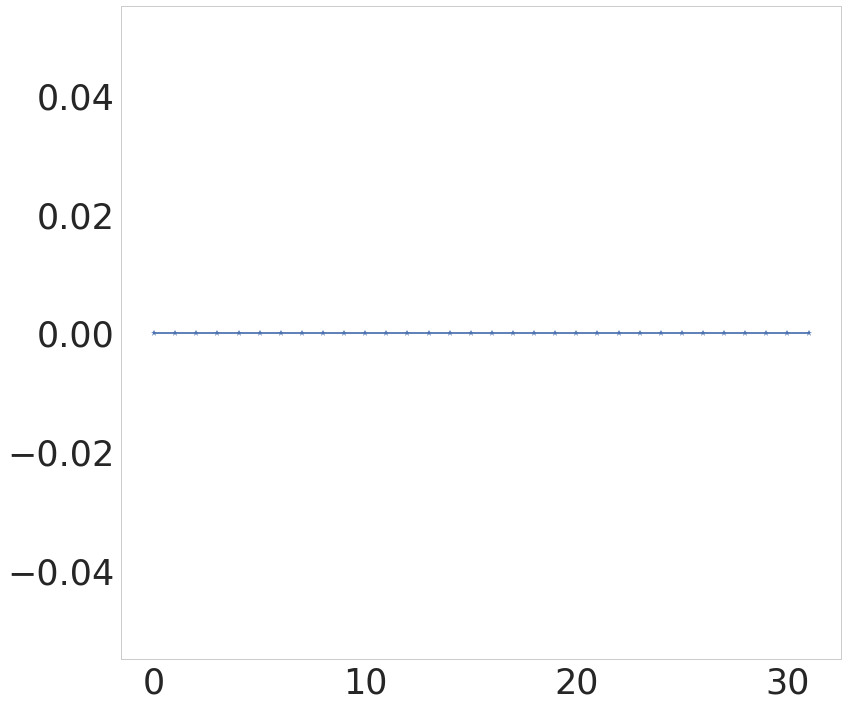

In [109]:
plt.plot(w_total[:, minicolumns * 2  + 4], '*-')

In [39]:
minicolumns * hypercolumns

15

In [52]:
minicolumns * 2  + 4

14

In [41]:
hypercolumns

3

In [42]:
m1

array([[0, 0, 0],
       [1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

In [43]:
m2

array([[0, 0, 4],
       [1, 1, 4],
       [2, 2, 4],
       [3, 3, 4]])

In [46]:
pi1

array([ 0.25035,  0.24873,  0.23636,  0.14302,  0.     ,  0.25035,
        0.24873,  0.23636,  0.14302,  0.     ,  0.25035,  0.24873,
        0.23636,  0.14302,  0.     ])

In [47]:
pi2

array([ 0.25035,  0.24873,  0.23636,  0.14302,  0.     ,  0.25035,
        0.24873,  0.23636,  0.14302,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.87846])